In [187]:
import Pkg
Pkg.activate("../../Tasks2D")

using Revise, Plots
import LineWorlds
const L = LineWorlds
const Geo = L.Geometry

import GridWorlds
const GW = GridWorlds

using Gen
import GenPOMDPs

using GenSMCP3
# We need this to help with dualizing and undualizing values...
const DFD = GenSMCP3.GenTraceKernelDSL.DynamicForwardDiff

using VoxelRayTracers # For lineworld -> gridworld
using AStarSearch     # For gridworld path planning

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


In [188]:
(_segs, _bb, _center) = L.load_env_sparse("/Users/georgematheos/Developer/research/summer2023/tasks2d/data/environments/ambig.json");

In [189]:
function line_to_grid(_segs, _bb, ϵ)
    (x1, y1), (x2, y2) = _bb
    edges = ((x1 - ϵ):ϵ:(x2 + ϵ), (y1 - ϵ):ϵ:(y2 + ϵ))

    grid = [false for _ in edges[1], _ in edges[2]]
    for seg in _segs
        if Geo.diff(seg) ≈ [0, 0]
            continue
        end
        ray = (position=seg.x, velocity=Geo.diff(seg))
        for hit in eachtraversal(ray, edges)
                                    # TODO: is this a hack or no?
            if hit.exit_time ≤ 1. #|| (hit.entry_time == 1.0 && (ray.velocity[1] > 0 || ray.velocity[2] > 0))
                grid[hit.voxelindex] = true
            end
        end
    end

    linecoords_to_gridcoords(x, y) = (
        Int(round((x - edges[1][1] + ϵ) / ϵ)),
        Int(round((y - edges[2][1] + ϵ) / ϵ))
    )
    gridcoords_to_linecoords(x, y) = (
        edges[1][x],
        edges[2][y]
    )

    return grid, edges, linecoords_to_gridcoords, gridcoords_to_linecoords
end

line_to_grid (generic function with 1 method)

In [190]:
ϵ = 0.25
(grid, edges, l_to_g, g_to_l) = line_to_grid(_segs, _bb, ϵ)
w = GridWorlds.boolmatrix_to_grid(grid, (length(edges[1]), length(edges[2])));

In [191]:
taxi_dist((x, y), (x2, y2)) = abs(x - x2) + abs(y - y2)
function find_action_using_grid_search(start_linecoords, goal_linecoords)
    actions = (:up, :down, :left, :right, :stay)
    initialpos = l_to_g(start_linecoords...)
    goalpos    = l_to_g(goal_linecoords...)

    results = astar(
        # state to neighbors
        pos -> unique(GW.newpos(w, pos, dir) for dir in actions),
        initialpos, # Initial world state
        goalpos; # Goal world state
        heuristic = ((pos, goal) -> taxi_dist(pos, goal)),
        isgoal = ((pos, goal) -> pos == goal),
        timeout = 10.
    )

    length(results.path) == 1 && return (:stay, results.path)
    
    next_state = results.path[2]
    # println("next_state: ", g_to_l(next_state...))
    action = actions[findfirst(
        GW.newpos(w, initialpos, dir) == next_state for dir in actions
    )]
    
#     @info "action = $action"
#     if action == :stay
#         println("a=stay | next_state = $next_state, current_pos = $initialpos")
#         println("GW.newpos(w, initialpos, dir) = $(GW.newpos(w, initialpos, :stay))")
#     end

    return (action, results.path)
end

find_action_using_grid_search (generic function with 1 method)

In [192]:
PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (;
        Δ = 0.25,
        σ = 0.02
    ),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.02,
            outlier      = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

In [193]:
mvuniform = L.ProductDistribution(uniform);
@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as list of line segments
    
    mins, maxs = PARAMS.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end
@load_generated_functions()

### Motion model ###
# The next position, under a 0-noise model, with no walls.
function det_next_pos(pos, a, Δ)
    (x, y) = DFD.value(pos)
    a == :up    ? [x, y + Δ] :
    a == :down  ? [x, y - Δ] : 
    a == :left  ? [x - Δ, y] :
    a == :right ? [x + Δ, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end
function handle_wall_intersection(prev, new, walls)
    move = L.Segment(DFD.value(prev), DFD.value(new))
    for wall in walls
        do_intersect, dist = L.Geometry.cast(move, wall)
        if do_intersect && dist ≤ L.Geometry.norm(move)
            return prev
        end
    end
    return new
end
@gen (static) function motion_model(prev_pos, action, PARAMS)
    np = det_next_pos(prev_pos, action, PARAMS.step.Δ)
    pos ~ broadcasted_normal(np, PARAMS.step.σ)
    
    next_pos = handle_wall_intersection(prev_pos, pos, PARAMS.map)
    
    return next_pos
end

### Observation model ###
@gen function sensor_model(pos, params)
    p = L.Pose(pos, params.orientation)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.sensor_args
    
    # segs = L.stack(Vector.(params.map))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    zs = L.cast([p], params.map; num_a=params.obs.n_rays, zmax)
    @assert !any(isinf.(zs))
    # zs = reshape(dists, (1, :))
    ỹ  = L.get_2d_mixture_components(zs, _as, w; fill_val_z=zmax)[1,:,:,:]
    @assert !any(isinf.(ỹ))

    # Observe a list of points, in the agent's coordinate frame.
    obs ~ L.sensordist_2dp3(ỹ, s_noise, outlier, outlier_vol)  

    if any(any(isinf.(o)) for o in obs)
        @warn "got an inf obs ỹ = $ỹ"
    end
    
    return obs
end;

# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

@load_generated_functions()

In [194]:
T(tr) = get_args(tr)[1]
currentpos(tr) = tr[state_addr(T(tr), :pos)]

currentpos (generic function with 1 method)

In [195]:
includet("05_inference.jl")

In [196]:
function get_actobs_seq(groundtruth_trace)
    return map(
        trace -> (
            GenPOMDPs.observation_sequence(trace),
            GenPOMDPs.action_sequence(trace)
        ),
        groundtruth_trace
    )
end

get_actobs_seq (generic function with 1 method)

In [197]:
_grid_args = (;
    tau = 1., # "temperature" for grid proposal
    pmin = 1e-6,
    init_grid_args = (;
        k = [9, 9],    # number of grid cells along each dimension
        r = [PARAMS.step.Δ/3, PARAMS.step.Δ/3] # size of grid cells at first iteration
    ),
    n_iters = 3 # number of iterations of grid proposals
)

_t0_grid_args = (;
    _grid_args...,
    tau=20,
    n_iters=5, # more iterations for the initial step

    # TODO: set this up to automatically look at the bounding box
    init_grid_args = (; k=[7, 13], r=[.8, .8]),
    initial_pos = [2.7, 6.] # center of grid for first timestep
)

PARAMS_NOISYSTEP = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (;
        Δ = 0.25,
        σ = 0.1
    ),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.1,
            outlier      = 0.001,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

pf = @get_pf(PARAMS_NOISYSTEP, _grid_args, _t0_grid_args);

In [198]:
state_addr = GenPOMDPs.state_addr

state_addr (generic function with 2 methods)

In [199]:
tr, take_action = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [1., 4.])));
pf_observable = GenPOMDPs.pf_observable(pf, get_actobs_seq(tr));

In [244]:
### Visualize first timestep particles ###

using Random
function visualize_tr_pf(tr, states, mint=nothing, maxt=nothing; goal=nothing, fps=1,
    title="Generated trajectory from POMDP",
    saveas=nothing
)
    poses = [
        L.Pose(position, PARAMS.orientation)
        for position in GenPOMDPs.state_sequence(tr)
    ];
    ptclouds = [
        obss[:obs].*pose
        for (obss, pose) in zip(
            GenPOMDPs.observation_sequence(tr),
            poses
        )
    ];

    if isnothing(mint)
        mint = 0
    end
    if isnothing(maxt)
        maxt = T(tr)
    end
    
    # -----------------------
    col = palette(:default)
    ani = Animation()
    # states = [state]
    for t=mint:maxt
        p = poses[t + 1]
        y = ptclouds[t + 1]
    
        agent_plt = plot(
            size=(500,500), aspect_ratio=:equal, title=title, grid=false,
            xlim=(_bb[1][1]-3, _bb[2][1]+3),
            ylim=(_bb[1][2]-3, _bb[2][2]+3),
            legend=:bottomleft,
        )
        plot!(_segs, c=:black, linewidth=1, label=nothing)
#         plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    
        particles = states[t + 1]
        labeled=false
        for (w, tr) in zip(
                GenParticleFilters.get_norm_weights(particles),
                GenParticleFilters.get_traces(particles)
            )
            pos = tr[GenPOMDPs.state_addr(t)]
            if !labeled && sqrt(w) > 0.1
                scatter!([pos], c=:black, seriesalpha=max(sqrt(w), 0.1), label="Particle")
                labeled=true
            else
                scatter!([pos], c=:black, seriesalpha=max(sqrt(w), 0.1), label=nothing)
            end
        end
        
        if !isnothing(goal)
           scatter!([goal], c=:green, marker=:x, label="Goal") 
        end
        
        scatter!([p.x], c=:red, marker=:x, label="True agent position")
    
        frame(ani, agent_plt)
    end
    if !isnothing(saveas)
        return gif(ani, "$saveas.gif", fps=fps) # gif(ani, fname, fps=10)
    else
        return gif(ani, fps=fps)
    end
end

visualize_tr_pf (generic function with 3 methods)

In [201]:
"""
st  - finite state machine state (direction of wall we're following)
nbs - neighbors of the agent on grid which are filled (set of dirs)
returns (action, next_st)

dirs = [:L, :R, :U, :D]
"""
function _wall_follow(st, nbs)
    isnothing(st) && :L ∉ nbs ? (:L, st) :
    isnothing(st) && :L ∈ nbs ? (:D, :L) :
    #
    st == :L && :L ∉ nbs ? (:L, :U) :
    st == :L && :D ∉ nbs ? (:D, :L) :
    st == :L && :R ∉ nbs ? (:R, :D) :
    st == :L             ? (:U, :R) :
    #
    st == :R && :R ∉ nbs ? (:R, :D) :
    st == :R && :U ∉ nbs ? (:U, :R) :
    st == :R && :L ∉ nbs ? (:L, :U) :
    st == :R             ? (:D, :L) :
    #
    st == :D && :D ∉ nbs ? (:D, :L) :
    st == :D && :R ∉ nbs ? (:R, :D) :
    st == :D && :U ∉ nbs ? (:U, :R) :
    st == :D             ? (:L, :U) :
    #
    st == :U && :U ∉ nbs ? (:U, :R) :
    st == :U && :L ∉ nbs ? (:L, :U) :
    st == :U && :D ∉ nbs ? (:D, :L) :
    st == :U             ? (:R, :D) :
    
    error("Unrecognized st/nbs pair.")
end

_wall_follow

In [202]:
initial_wall_follow_state() = Any[nothing]
function wall_follow_from_pos(pos, st)
    (x, y) = pos

    # Find which sides of the agent have walls
    # (the agent's "neighbors")
    nbs = Set()
    δ = 1.25*ϵ
    for (a, newpos) in (
        (:U, [x, y + δ]), (:D, [x, y - δ]), (:L, [x - δ, y]), (:R, [x + δ, y])
    )
        if handle_wall_intersection([x, y], newpos, PARAMS.map) != newpos
            push!(nbs, a)
        end
    end
    
    (a, st) = _wall_follow(st, nbs)
    
    act = (;U=:up,L=:left,D=:down,R=:right)[a]
    
    return (act, st)

end
function wall_follow(sts, pos)
    (a, st) = wall_follow_from_pos(pos, sts[end])
    sts = vcat(sts, [st])
    
    # Prevent cycles
    if length(sts)>8 && sts[end-3:end] == sts[end-7:end-4] && length(Set(sts[end-3:end])) == 4
        sts[end] = nothing
    end
    
    return (a, sts)
end

wall_follow (generic function with 1 method)

In [203]:
# function there_is_ambiguity(pf_state)
#     pts = [] # set of unique positions
#     for tr in GPF.get_traces(pf_state)
#         if isempty(pts)
#             push!(pts, currentpos(tr))
#         else
#             is_replicate = false
#             for pt in pts
#                 if Geo.norm(currentpos(tr) - pt) < 0.5
#                     is_replicate = true
#                     continue
#                 end
#             end
#             # If this trace has a significantly different position
#             # than the first one we found...
#             if !is_replicate
#                 push!(pts, currentpos(tr))
#                 return true # There IS ambiguity
#             end
#         end
#     end
#     return false
# end

function there_is_ambiguity(pf_state)
    tr1 = first(GPF.get_traces(pf_state))
    pos = currentpos(tr1)
    
    p_different = 0.
    for (tr, p_particle) in zip(GPF.get_traces(pf_state), GPF.get_norm_weights(pf_state))
        if Geo.norm(currentpos(tr) - pos) > .5
            p_different += p_particle
        end
    end
    
    return p_different > 0
end

there_is_ambiguity (generic function with 1 method)

In [204]:
GOAL = [2., 8.] # In one of the identical rooms

2-element Vector{Float64}:
 2.0
 8.0

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/tmp.gif")
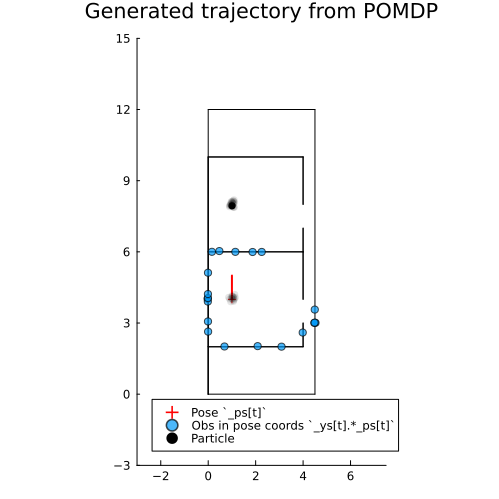

In [236]:
tr, take_action = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [1., 4.])));
pf_observable = GenPOMDPs.pf_observable(pf, get_actobs_seq(tr));

visualize_tr_pf(tr[], pf_observable[], 0, 0)

In [237]:
wall_following_internal_state = initial_wall_follow_state()
while Geo.norm(currentpos(tr[]) - GOAL) > .3 && T(tr[]) < 100
    _tr = GPF.sample_unweighted_traces(pf_observable[][end], 1)[1]
    pos = _tr[state_addr(T(_tr), :pos)]
    
    if there_is_ambiguity(pf_observable[][end])
        prev_st = wall_following_internal_state
        (action, next_st) = wall_follow(wall_following_internal_state, pos)
        wall_following_internal_state = next_st
        
        msg = "WF ($(prev_st[end])) -> $((action, next_st[end]))"
    else
        action = find_action_using_grid_search2(pos, GOAL)[1]
        
        msg = "GS -> $action"

        # Reset the wall following policy
        wall_following_internal_state = initial_wall_follow_state()
    end
    println(msg)
    
    take_action(action)
end

WF (nothing) -> (:left, nothing)
WF (nothing) -> (:left, nothing)
WF (nothing) -> (:left, nothing)
WF (nothing) -> (:down, :L)
WF (L) -> (:down, :L)
WF (L) -> (:down, :L)
WF (L) -> (:down, :L)
WF (L) -> (:down, :L)
WF (L) -> (:down, :L)
WF (L) -> (:down, :L)
WF (L) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:right, :D)
WF (D) -> (:up, :R)
WF (R) -> (:up, :R)
WF (R) -> (:up, :R)
WF (R) -> (:right, :D)
WF (D) -> (:down, :L)
WF (L) -> (:left, :U)
WF (U) -> (:up, :R)
WF (R) -> (:right, :D)
WF (D) -> (:down, :L)
Resampling!
GS -> up
GS -> up
GS -> up
GS -> right
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> up
GS -> left
GS -> up
GS -> left
GS -> up
G

In [248]:
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Agent's path to goal (BSQ Policy)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, label="Walls")
scatter!([GOAL], c=:green, marker=:x, label="Goal")
plot!(GenPOMDPs.state_sequence(tr[]), c=:red, label="Agent path")
png("bsq_path.png")

"bsq_path.png"

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/BSQ_v1.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/BSQ_v1.gif")
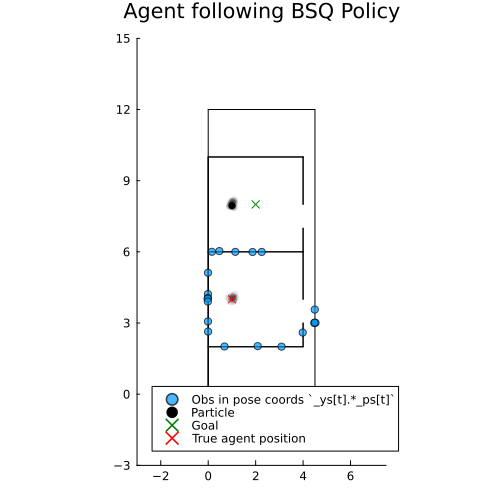

In [245]:
visualize_tr_pf(tr[], pf_observable[]; goal=GOAL, fps=4,
    saveas="BSQ_v1",
    title="Agent following BSQ Policy"
)

In [154]:
pos = pf_observable[][end].traces[1][state_addr(50)]

2-element Vector{Float64}:
 3.655823193287571
 1.8037627688273672

In [170]:
# tr[][state_addr(50)]
(a, path) = find_action_using_grid_search(pos, GOAL)

(:up, [(18, 14), (18, 15), (18, 16), (18, 17), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22)  …  (17, 32), (17, 33), (17, 34), (16, 34), (15, 34), (14, 34), (13, 34), (12, 34), (11, 34), (10, 34)])

In [166]:
length(path)

31

In [145]:
pos = tr[][state_addr(50)]

2-element Vector{Float64}:
 3.178686006607512
 1.753689016850281

In [146]:
l_to_g(pos...)

(15, 9)